Loaded 23258 clear cut polygons
Available metrics: ['area_ha', 'perimeter_m', 'length_m', 'width_m', 'equivalent_diameter_m', 'shape_index', 'perimeter_area_ratio', 'compactness_index', 'fractal_dimension_index', 'elongation_ratio', 'orientation_degrees', 'edge_density']
=== BASIC DESCRIPTIVE STATISTICS ===
                             area_ha  perimeter_m    length_m     width_m  \
count                     23257.0000   23257.0000  23257.0000  23257.0000   
mean                          0.7333     447.0112    123.6922     90.1144   
std                           0.5637     228.5021     55.2245     38.8845   
min                           0.1300     160.0000     50.0000     30.0000   
5%                            0.3600     240.0000     60.0000     60.0000   
25%                           0.4500     300.0000     90.0000     60.0000   
50%                           0.5400     360.0000    120.0000     90.0000   
75%                           0.8100     480.0000    150.0000     90.0000  

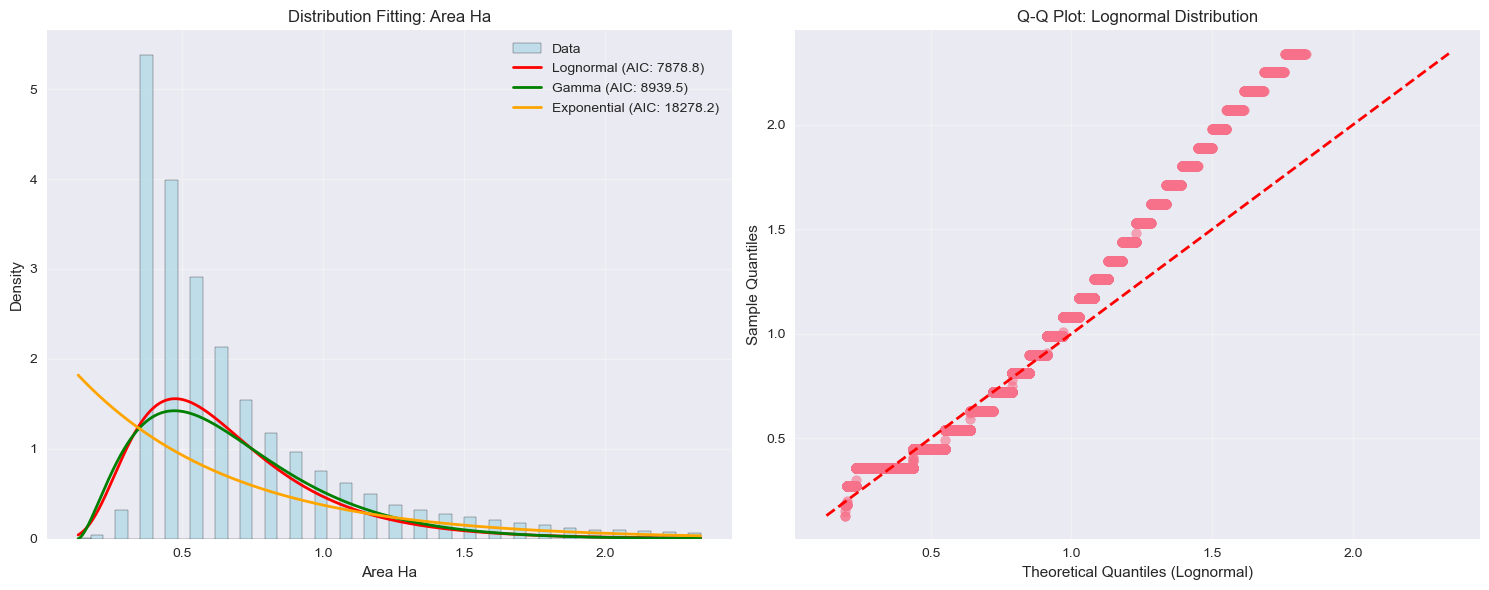


=== Distribution Analysis for shape_index ===
Failed to fit beta for shape_index: Invalid values in `data`.  Maximum likelihood estimation with 'beta' requires that 0 < (x - loc)/scale  < 1 for each x in `data`.


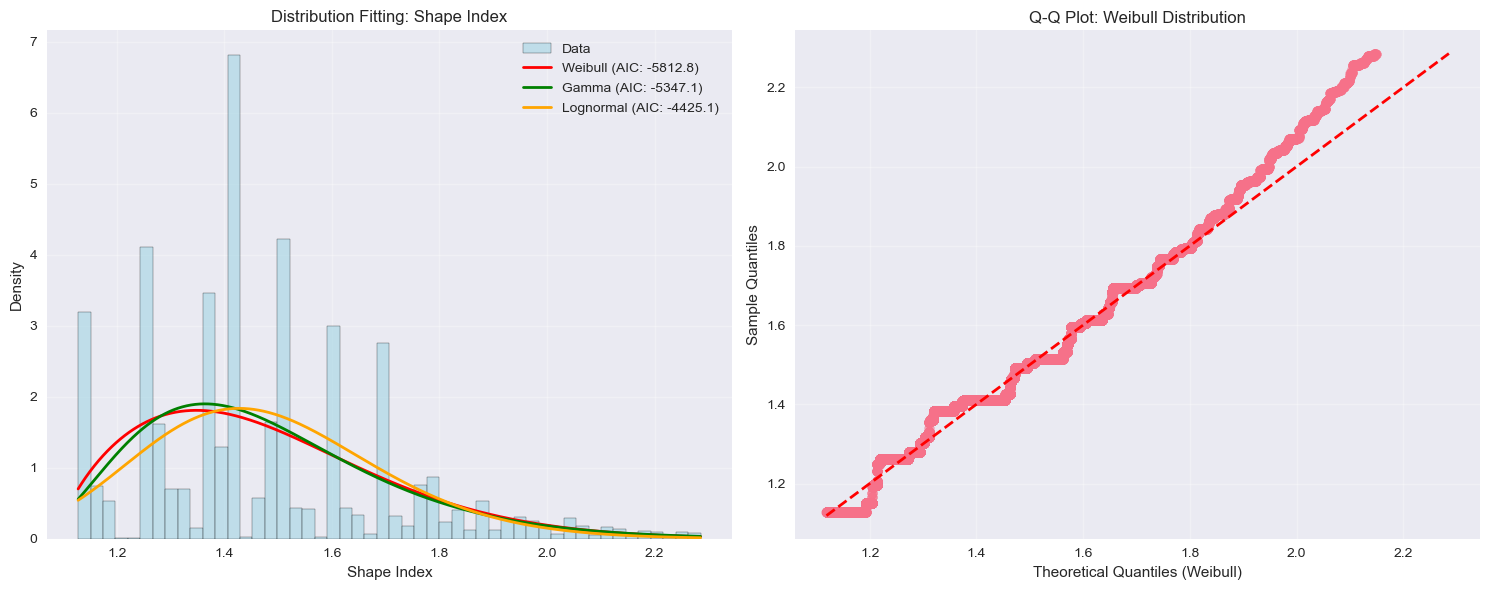


=== Distribution Analysis for elongation_ratio ===
Failed to fit beta for elongation_ratio: Invalid values in `data`.  Maximum likelihood estimation with 'beta' requires that 0 < (x - loc)/scale  < 1 for each x in `data`.


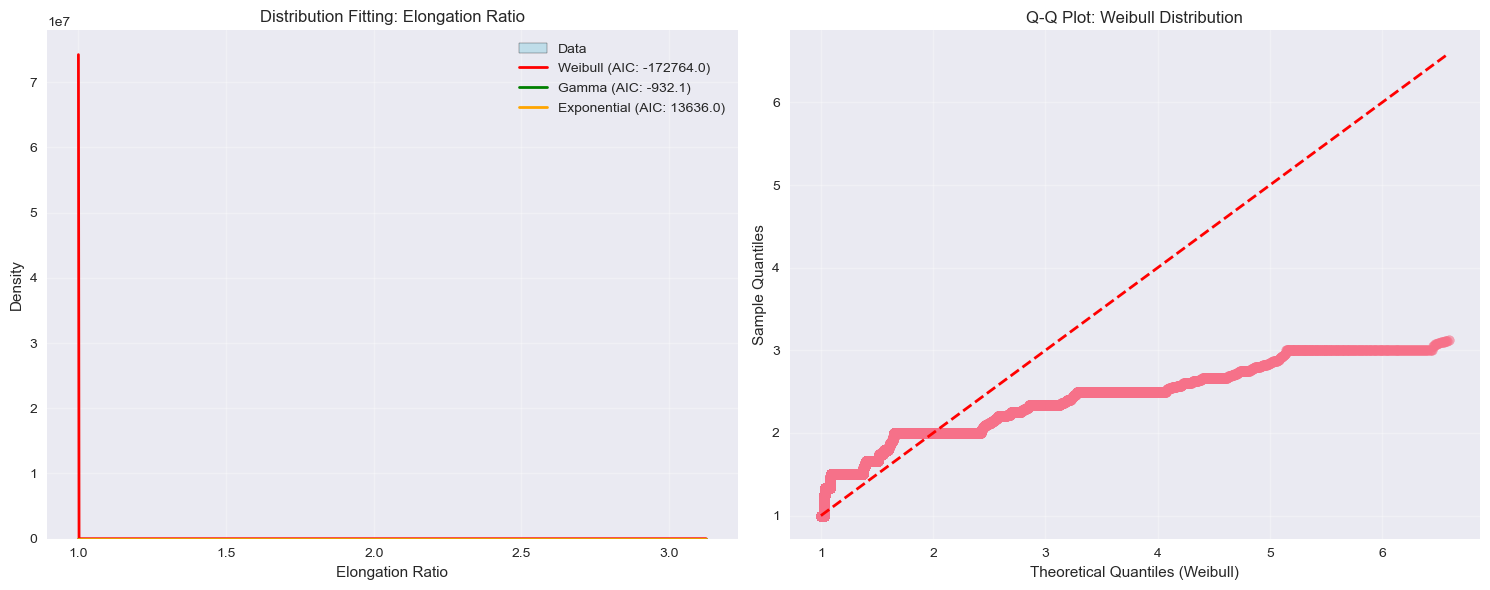


=== Distribution Analysis for compactness_index ===


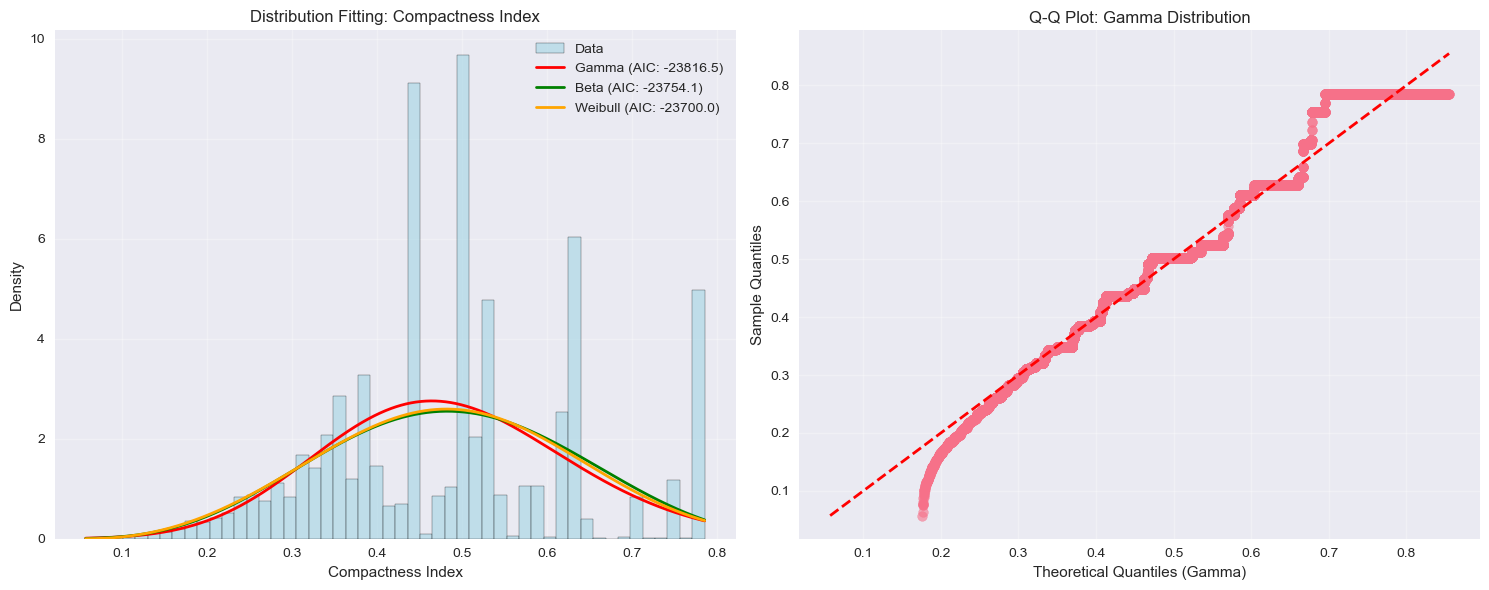

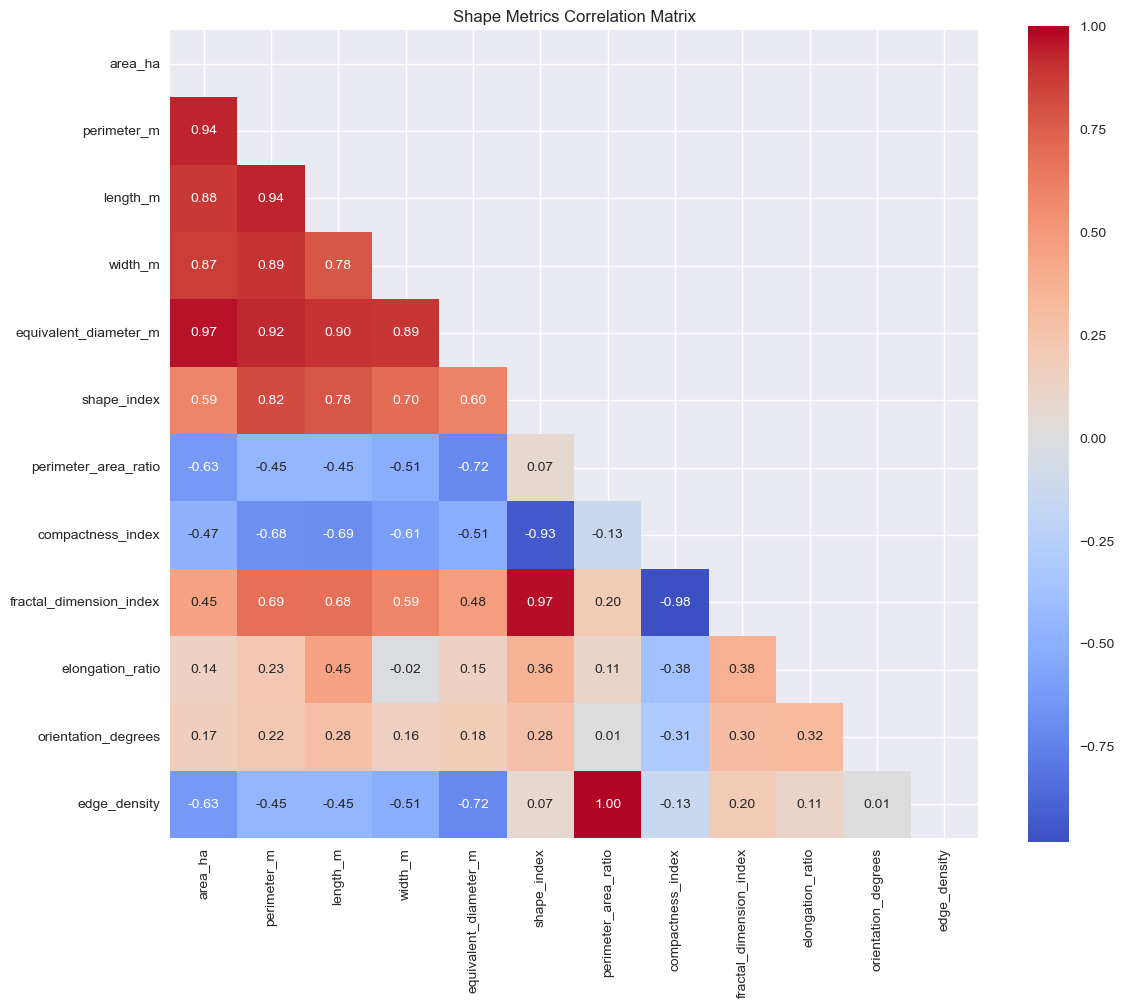

Results exported to shape_distribution_results.csv

=== ANALYSIS COMPLETE ===
Key findings saved to 'shape_distribution_results.csv'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (norm, lognorm, gamma, weibull_min, beta, 
                        kstest, anderson, jarque_bera)
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ShapeMetricsAnalyzer:
    def __init__(self, csv_file_path):
        """
        Initialize the analyzer with the CSV file from QGIS
        """
        self.df = pd.read_csv(csv_file_path)
        self.results = {}
        
        # Define metrics to analyze
        self.shape_metrics = [
            'area_ha',
            'perimeter_m', 
            'length_m',
            'width_m',
            'equivalent_diameter_m',
            'shape_index',
            'perimeter_area_ratio',
            'compactness_index',
            'fractal_dimension_index',
            'elongation_ratio',
            'orientation_degrees',
            'edge_density'
        ]
        
        # Define distributions to test
        self.distributions = {
            'normal': stats.norm,
            'lognormal': stats.lognorm,
            'gamma': stats.gamma,
            'weibull': stats.weibull_min,
            'beta': stats.beta,
            'exponential': stats.expon
        }
        
        print(f"Loaded {len(self.df)} clear cut polygons")
        print(f"Available metrics: {self.shape_metrics}")
    
    def basic_statistics(self):
        """
        Calculate descriptive statistics for all metrics
        """
        print("=== BASIC DESCRIPTIVE STATISTICS ===")
        
        stats_df = self.df[self.shape_metrics].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
        
        # Add additional statistics
        additional_stats = pd.DataFrame({
            'skewness': self.df[self.shape_metrics].skew(),
            'kurtosis': self.df[self.shape_metrics].kurtosis(),
            'coefficient_of_variation': self.df[self.shape_metrics].std() / self.df[self.shape_metrics].mean()
        }).T
        
        # Combine statistics
        full_stats = pd.concat([stats_df, additional_stats])
        
        print(full_stats.round(4))
        return full_stats
    
    def fit_distributions(self, metric):
        """
        Fit multiple probability distributions to a given metric
        """
        data = self.df[metric].dropna()
        
        # Remove outliers (beyond 3 standard deviations)
        z_scores = np.abs(stats.zscore(data))
        data_clean = data[z_scores < 3]
        
        if len(data_clean) < 10:
            print(f"Warning: Not enough data points for {metric}")
            return None
        
        results = {}
        
        for dist_name, distribution in self.distributions.items():
            try:
                # Fit distribution
                if dist_name == 'lognormal':
                    # Special handling for lognormal
                    params = distribution.fit(data_clean, floc=0)
                elif dist_name == 'beta':
                    # Beta distribution needs data between 0 and 1
                    if data_clean.min() >= 0 and data_clean.max() <= 1:
                        params = distribution.fit(data_clean, floc=0, fscale=1)
                    else:
                        # Normalize data for beta distribution
                        data_norm = (data_clean - data_clean.min()) / (data_clean.max() - data_clean.min())
                        params = distribution.fit(data_norm, floc=0, fscale=1)
                else:
                    params = distribution.fit(data_clean)
                
                # Calculate goodness of fit metrics
                
                # Log-likelihood
                log_likelihood = np.sum(distribution.logpdf(data_clean, *params))
                
                # AIC and BIC
                k = len(params)  # Number of parameters
                n = len(data_clean)  # Sample size
                aic = 2 * k - 2 * log_likelihood
                bic = k * np.log(n) - 2 * log_likelihood
                
                # Kolmogorov-Smirnov test
                ks_statistic, ks_p_value = kstest(data_clean, 
                                                 lambda x: distribution.cdf(x, *params))
                
                # Anderson-Darling test (only for normal, exponential, logistic)
                ad_statistic, ad_p_value = None, None
                if dist_name in ['normal', 'exponential']:
                    try:
                        ad_result = anderson(data_clean, dist=dist_name)
                        ad_statistic = ad_result.statistic
                        # Approximate p-value calculation
                        ad_p_value = 1.0 if ad_statistic < ad_result.critical_values[2] else 0.01
                    except:
                        pass
                
                results[dist_name] = {
                    'parameters': params,
                    'log_likelihood': log_likelihood,
                    'aic': aic,
                    'bic': bic,
                    'ks_statistic': ks_statistic,
                    'ks_p_value': ks_p_value,
                    'ad_statistic': ad_statistic,
                    'ad_p_value': ad_p_value,
                    'sample_size': len(data_clean)
                }
                
            except Exception as e:
                print(f"Failed to fit {dist_name} for {metric}: {str(e)}")
                continue
        
        return results
    
    def find_best_distribution(self, metric):
        """
        Find the best fitting distribution based on AIC
        """
        fit_results = self.fit_distributions(metric)
        
        if not fit_results:
            return None
        
        # Sort by AIC (lower is better)
        best_dist = min(fit_results.items(), key=lambda x: x[1]['aic'])
        
        return best_dist[0], fit_results
    
    def plot_distribution_comparison(self, metric, top_n=3):
        """
        Plot histogram with fitted distributions overlay
        """
        data = self.df[metric].dropna()
        z_scores = np.abs(stats.zscore(data))
        data_clean = data[z_scores < 3]
        
        best_dist_name, fit_results = self.find_best_distribution(metric)
        
        if not fit_results:
            return
        
        # Sort distributions by AIC and take top N
        sorted_dists = sorted(fit_results.items(), key=lambda x: x[1]['aic'])[:top_n]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot histogram
        ax1.hist(data_clean, bins=50, density=True, alpha=0.7, color='lightblue', 
                edgecolor='black', label='Data')
        
        # Plot fitted distributions
        x = np.linspace(data_clean.min(), data_clean.max(), 1000)
        colors = ['red', 'green', 'orange', 'purple', 'brown']
        
        for i, (dist_name, results) in enumerate(sorted_dists):
            distribution = self.distributions[dist_name]
            params = results['parameters']
            
            try:
                y = distribution.pdf(x, *params)
                ax1.plot(x, y, colors[i], linewidth=2, 
                        label=f'{dist_name.title()} (AIC: {results["aic"]:.1f})')
            except:
                continue
        
        ax1.set_xlabel(metric.replace('_', ' ').title())
        ax1.set_ylabel('Density')
        ax1.set_title(f'Distribution Fitting: {metric.replace("_", " ").title()}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Q-Q plot for best distribution
        best_dist = self.distributions[best_dist_name]
        best_params = fit_results[best_dist_name]['parameters']
        
        # Generate theoretical quantiles
        theoretical_quantiles = best_dist.ppf(np.linspace(0.01, 0.99, len(data_clean)), 
                                            *best_params)
        sample_quantiles = np.sort(data_clean)
        
        ax2.scatter(theoretical_quantiles, sample_quantiles, alpha=0.6)
        
        # Add diagonal line
        min_val = min(theoretical_quantiles.min(), sample_quantiles.min())
        max_val = max(theoretical_quantiles.max(), sample_quantiles.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        ax2.set_xlabel(f'Theoretical Quantiles ({best_dist_name.title()})')
        ax2.set_ylabel('Sample Quantiles')
        ax2.set_title(f'Q-Q Plot: {best_dist_name.title()} Distribution')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return sorted_dists
    
    def analyze_all_metrics(self):
        """
        Perform comprehensive analysis for all shape metrics
        """
        print("=== COMPREHENSIVE DISTRIBUTION ANALYSIS ===\n")
        
        summary_results = {}
        
        for metric in self.shape_metrics:
            print(f"\n--- Analyzing {metric.replace('_', ' ').title()} ---")
            
            # Get basic stats
            data = self.df[metric].dropna()
            print(f"Sample size: {len(data)}")
            print(f"Mean: {data.mean():.4f}")
            print(f"Std: {data.std():.4f}")
            print(f"Range: {data.min():.4f} - {data.max():.4f}")
            
            # Find best distribution
            best_dist_name, fit_results = self.find_best_distribution(metric)
            
            if fit_results:
                # Display top 3 distributions
                sorted_dists = sorted(fit_results.items(), key=lambda x: x[1]['aic'])[:3]
                
                print("\nTop 3 Distributions (by AIC):")
                for i, (dist_name, results) in enumerate(sorted_dists, 1):
                    print(f"{i}. {dist_name.title()}: AIC = {results['aic']:.2f}, "
                          f"KS p-value = {results['ks_p_value']:.4f}")
                
                # Store best distribution info
                best_result = fit_results[best_dist_name]
                summary_results[metric] = {
                    'best_distribution': best_dist_name,
                    'parameters': best_result['parameters'],
                    'aic': best_result['aic'],
                    'ks_p_value': best_result['ks_p_value'],
                    'sample_size': best_result['sample_size']
                }
        
        # Create summary DataFrame
        summary_df = pd.DataFrame(summary_results).T
        self.results = summary_results
        
        return summary_df
    
    def export_results(self, output_file='shape_distribution_results.csv'):
        """
        Export analysis results to CSV
        """
        if not self.results:
            print("No results to export. Run analyze_all_metrics() first.")
            return
        
        # Prepare data for export
        export_data = []
        
        for metric, result in self.results.items():
            row = {
                'metric': metric,
                'best_distribution': result['best_distribution'],
                'aic': result['aic'],
                'ks_p_value': result['ks_p_value'],
                'sample_size': result['sample_size'],
                'parameters': str(result['parameters'])
            }
            
            # Add basic statistics
            data = self.df[metric].dropna()
            row.update({
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'median': data.median(),
                'q25': data.quantile(0.25),
                'q75': data.quantile(0.75),
                'skewness': data.skew(),
                'kurtosis': data.kurtosis()
            })
            
            export_data.append(row)
        
        export_df = pd.DataFrame(export_data)
        export_df.to_csv(output_file, index=False)
        print(f"Results exported to {output_file}")
        
        return export_df
    
    def plot_correlation_matrix(self):
        """
        Plot correlation matrix of all shape metrics
        """
        plt.figure(figsize=(12, 10))
        corr_matrix = self.df[self.shape_metrics].corr()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
                   center=0, square=True, fmt='.2f')
        
        plt.title('Shape Metrics Correlation Matrix')
        plt.tight_layout()
        plt.show()
        
        return corr_matrix

# Usage Example
def main(csv_file_path):
    """
    Main analysis function
    """
    # Initialize analyzer
    analyzer = ShapeMetricsAnalyzer(csv_file_path)
    
    # Basic statistics
    basic_stats = analyzer.basic_statistics()
    
    # Comprehensive analysis
    summary = analyzer.analyze_all_metrics()
    
    # Plot examples for key metrics
    key_metrics = ['area_ha', 'shape_index', 'elongation_ratio', 'compactness_index']
    
    for metric in key_metrics:
        if metric in analyzer.df.columns:
            print(f"\n=== Distribution Analysis for {metric} ===")
            analyzer.plot_distribution_comparison(metric)
    
    # Correlation analysis
    corr_matrix = analyzer.plot_correlation_matrix()
    
    # Export results
    results_df = analyzer.export_results()
    
    return analyzer, summary, results_df

# Run the analysis
if __name__ == "__main__":
    # Replace with your CSV file path
    csv_file_path = "clear_cut_shape_metrics.csv"
    
    analyzer, summary, results = main(csv_file_path)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print("Key findings saved to 'shape_distribution_results.csv'")

=== SIZE-SHAPE RELATIONSHIP ANALYSIS ===

Loaded 23258 clear cuts
Size class distribution:
size_class
Large      9807
Medium      811
Small     12640
Name: count, dtype: int64


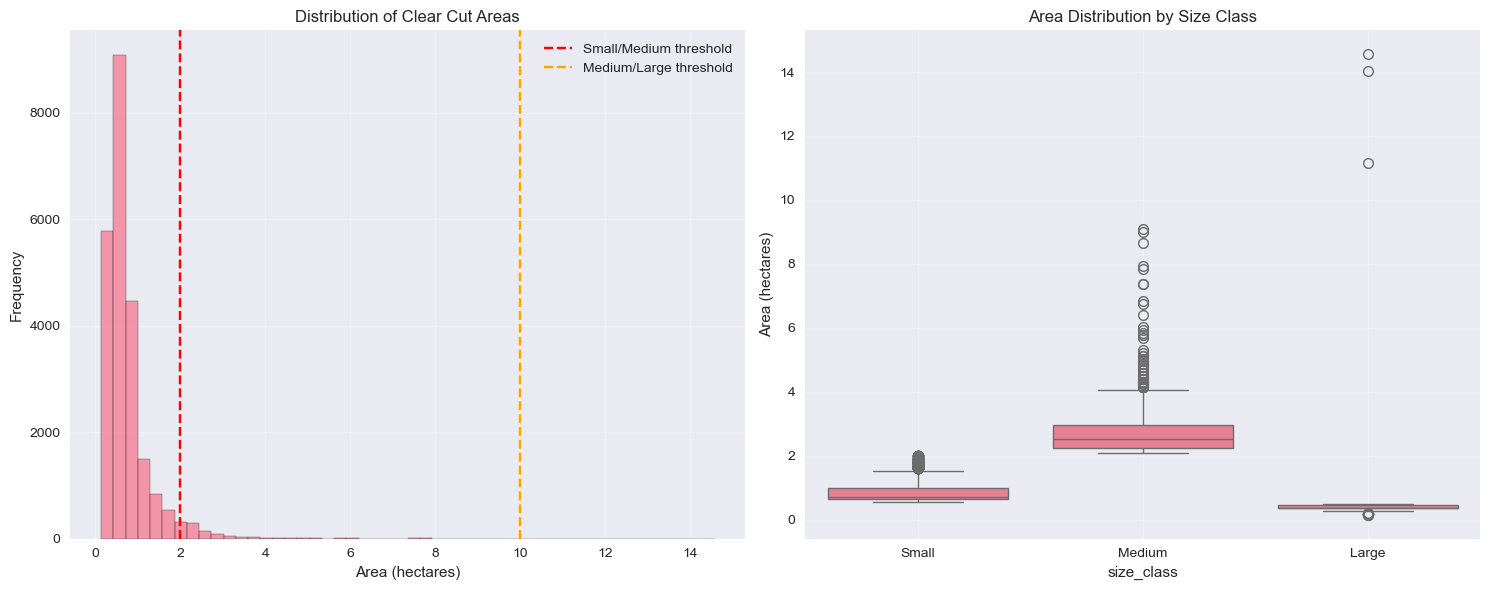

=== SCALING RELATIONSHIP ANALYSIS ===

--- Analyzing Shape Index vs. Area ---
Sample size: 22920
Linear relationship: R² = 0.2474, p = 0.0000
  y = 1.3072 + 0.2411*x
Power law (log-log): R² = 0.2573, p = 0.0000
  y = 1.5739 * x^0.1502
Power law (fitted): R² = 0.2690
  y = 1.5898 * x^0.1535
Interpretation: Positive scaling (increases with area)
Best fit: Power law

--- Analyzing Compactness Index vs. Area ---
Sample size: 23257
Linear relationship: R² = 0.2219, p = 0.0000
  y = 0.5745 + -0.1219*x
Power law (log-log): R² = 0.3190, p = 0.0000
  y = 0.3907 * x^-0.3474
Power law (fitted): R² = 0.2645
  y = 0.4133 * x^-0.3082
Interpretation: Negative scaling (decreases with area)
Best fit: Power law

--- Analyzing Elongation Ratio vs. Area ---
Sample size: 22924
Linear relationship: R² = 0.0237, p = 0.0000
  y = 1.4068 + 0.1209*x
Power law (log-log): R² = 0.0290, p = 0.0000
  y = 1.5000 * x^0.0900
Power law (fitted): R² = 0.0319
  y = 1.5639 * x^0.0961
Interpretation: No scaling relationship

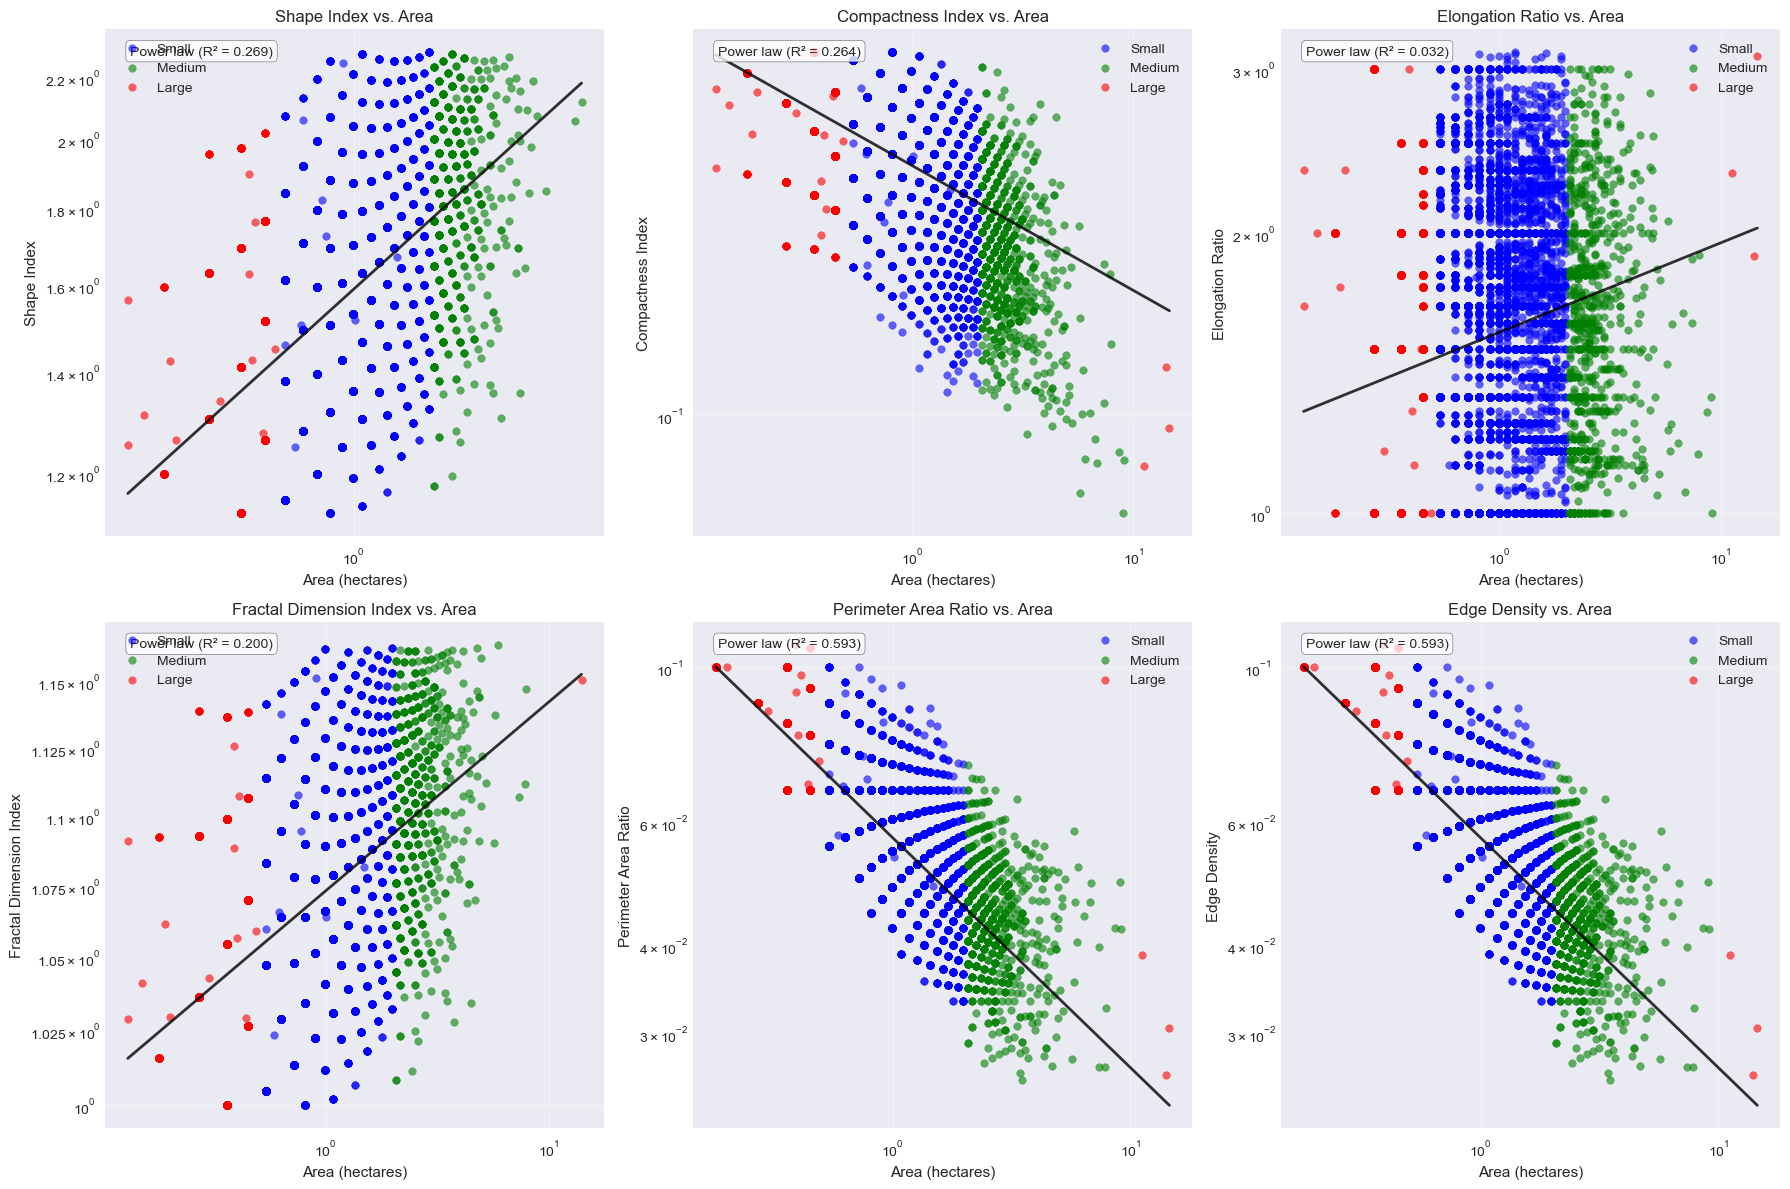


=== SIZE CLASS DISTRIBUTION ANALYSIS ===

--- Shape Index by Size Class ---
Small: n=12640, mean=1.5441, std=0.2477
Medium: n=811, mean=2.0359, std=0.4270
Large: n=9806, mean=1.3816, std=0.1772
ANOVA: F = 3719.2534, p = 0.000000
Significant differences between size classes (p < 0.05)

--- Compactness Index by Size Class ---
Small: n=12640, mean=0.4490, std=0.1286
Medium: n=811, mean=0.2719, std=0.1074
Large: n=9806, mean=0.5492, std=0.1365
ANOVA: F = 2715.7962, p = 0.000000
Significant differences between size classes (p < 0.05)

--- Elongation Ratio by Size Class ---
Small: n=12640, mean=1.5542, std=0.5220
Medium: n=811, mean=1.7639, std=0.7101
Large: n=9806, mean=1.4821, std=0.5230
ANOVA: F = 132.1364, p = 0.000000
Significant differences between size classes (p < 0.05)

--- Fractal Dimension Index by Size Class ---
Small: n=12640, mean=1.0666, std=0.0326
Medium: n=811, mean=1.1114, std=0.0382
Large: n=9806, mean=1.0470, std=0.0303
ANOVA: F = 2149.4869, p = 0.000000
Significant diff

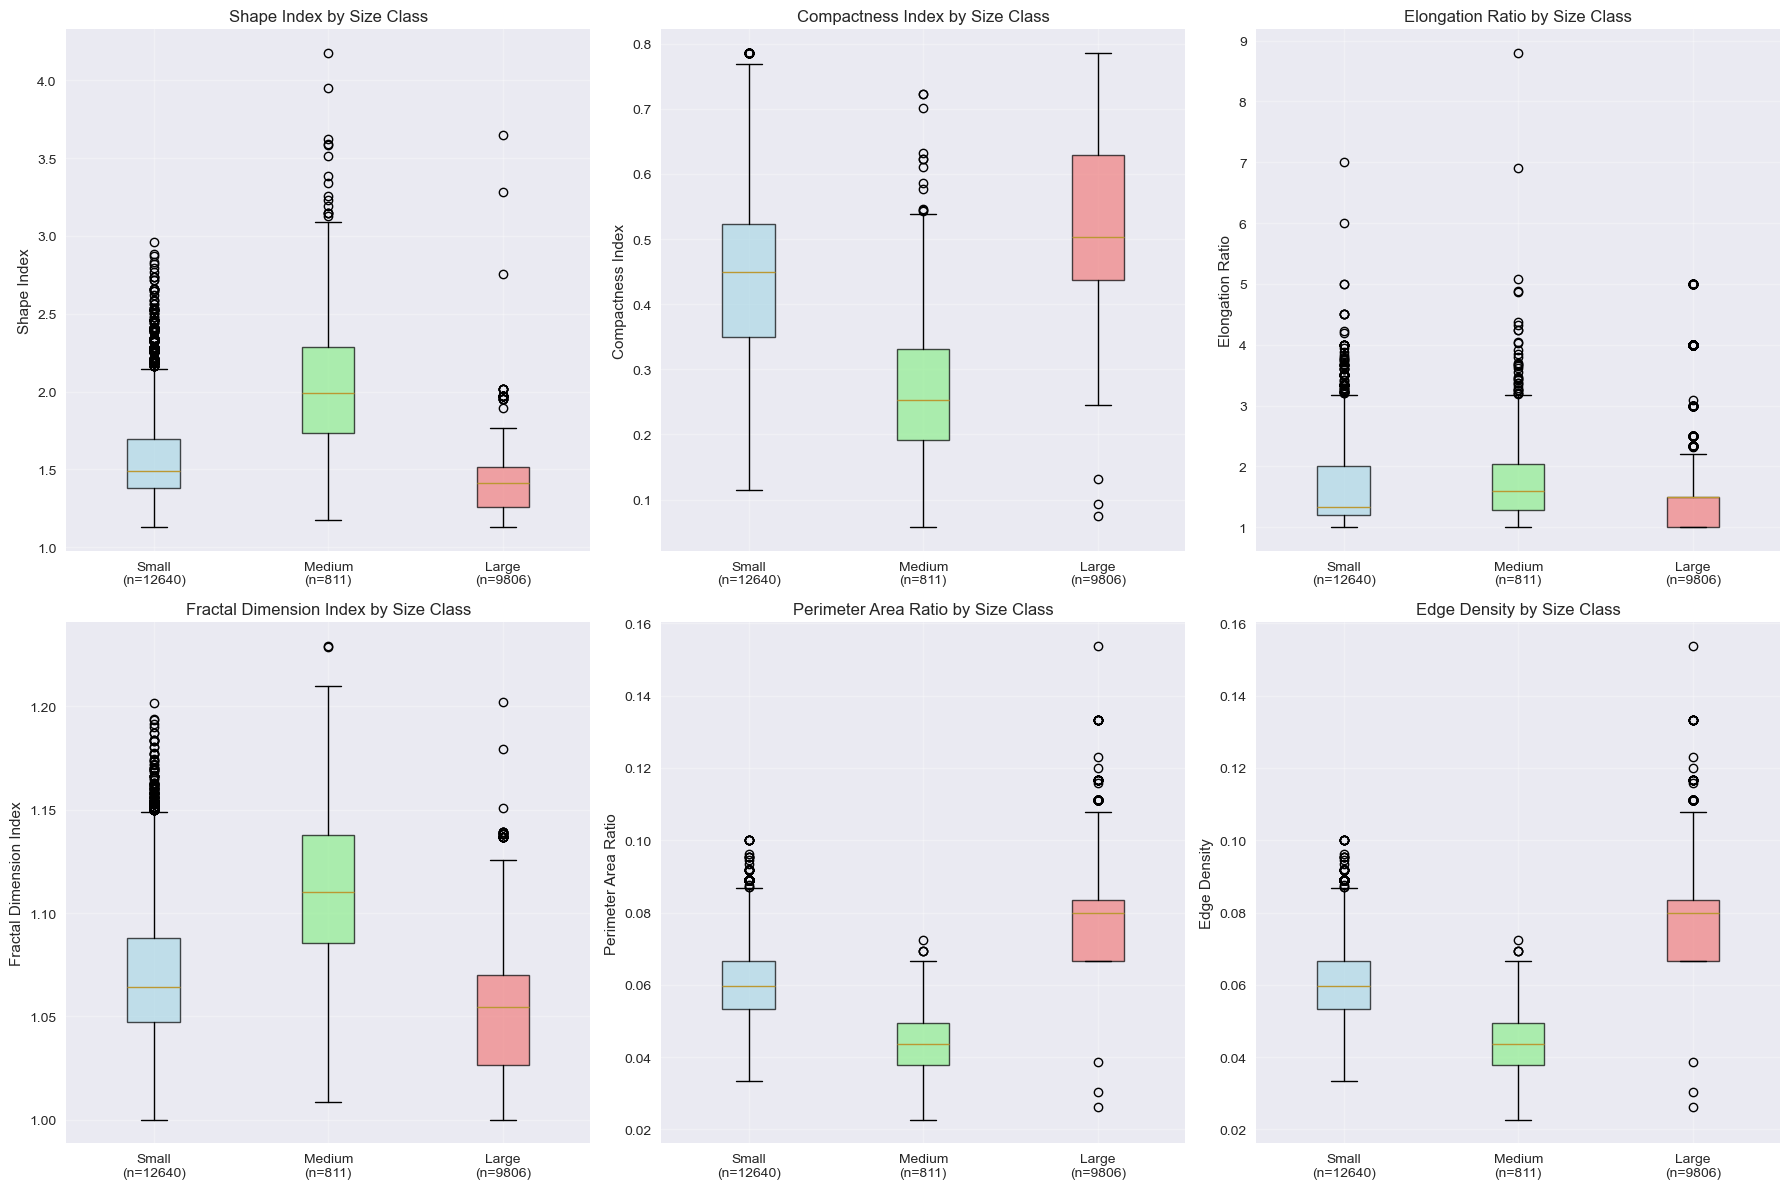


=== SIZE THRESHOLD ANALYSIS ===

--- Analyzing thresholds for Shape Index ---
Best threshold: 4.0 hectares
Significance score: 269.29 (-log10(p))
P-value: 0.000000
Mean below threshold: 1.4894
Mean above threshold: 2.5857
Difference: 1.0962

--- Analyzing thresholds for Compactness Index ---
Best threshold: 2.5 hectares
Significance score: 250.86 (-log10(p))
P-value: 0.000000
Mean below threshold: 0.4894
Mean above threshold: 0.2499
Difference: 0.2395

--- Analyzing thresholds for Elongation Ratio ---
Best threshold: 1.0 hectares
Significance score: 85.36 (-log10(p))
P-value: 0.000000
Mean below threshold: 1.5003
Mean above threshold: 1.6833
Difference: 0.1829

--- Analyzing thresholds for Fractal Dimension Index ---
Best threshold: 2.5 hectares
Significance score: 278.56 (-log10(p))
P-value: 0.000000
Mean below threshold: 1.0588
Mean above threshold: 1.1188
Difference: 0.0600

--- Analyzing thresholds for Perimeter Area Ratio ---
Best threshold: 2.5 hectares
Significance score: 307.7

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class SizeShapeAnalyzer:
    def __init__(self, csv_file_path):
        """
        Initialize analyzer with shape metrics CSV
        """
        self.df = pd.read_csv(csv_file_path)
        
        # Define size classes
        self.size_classes = {
            'Small': (0.5, 2.0),
            'Medium': (2.0, 10.0),
            'Large': (10.0, float('inf'))
        }
        
        # Add size class column
        self.df['size_class'] = self.df['area_ha'].apply(self._classify_size)
        
        # Define shape metrics for analysis
        self.shape_metrics = [
            'shape_index',
            'compactness_index',
            'elongation_ratio',
            'fractal_dimension_index',
            'perimeter_area_ratio',
            'edge_density'
        ]
        
        print(f"Loaded {len(self.df)} clear cuts")
        print(f"Size class distribution:")
        print(self.df['size_class'].value_counts().sort_index())
    
    def _classify_size(self, area):
        """Classify area into size classes"""
        for size_class, (min_area, max_area) in self.size_classes.items():
            if min_area <= area < max_area:
                return size_class
        return 'Large'  # For areas >= 10 ha
    
    def plot_area_distribution(self):
        """
        Plot distribution of clear cut areas
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histogram
        ax1.hist(self.df['area_ha'], bins=50, alpha=0.7, edgecolor='black')
        ax1.axvline(2.0, color='red', linestyle='--', label='Small/Medium threshold')
        ax1.axvline(10.0, color='orange', linestyle='--', label='Medium/Large threshold')
        ax1.set_xlabel('Area (hectares)')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Distribution of Clear Cut Areas')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot by size class
        size_order = ['Small', 'Medium', 'Large']
        sns.boxplot(data=self.df, x='size_class', y='area_ha', order=size_order, ax=ax2)
        ax2.set_ylabel('Area (hectares)')
        ax2.set_title('Area Distribution by Size Class')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def power_law_function(self, x, a, b):
        """Power law function: y = a * x^b"""
        return a * np.power(x, b)
    
    def linear_function(self, x, a, b):
        """Linear function: y = a + b*x"""
        return a + b * x
    
    def analyze_scaling_relationships(self):
        """
        Analyze power law and linear relationships between area and shape metrics
        """
        print("=== SCALING RELATIONSHIP ANALYSIS ===\n")
        
        results = {}
        
        for metric in self.shape_metrics:
            print(f"--- Analyzing {metric.replace('_', ' ').title()} vs. Area ---")
            
            # Clean data (remove outliers and invalid values)
            clean_data = self.df[(self.df[metric] > 0) & 
                               (self.df['area_ha'] > 0) & 
                               (np.isfinite(self.df[metric])) & 
                               (np.isfinite(self.df['area_ha']))].copy()
            
            if len(clean_data) < 10:
                print(f"Not enough valid data for {metric}")
                continue
            
            x = clean_data['area_ha'].values
            y = clean_data[metric].values
            
            # Remove extreme outliers (beyond 3 standard deviations)
            z_scores = np.abs(stats.zscore(y))
            mask = z_scores < 3
            x, y = x[mask], y[mask]
            
            if len(x) < 10:
                continue
            
            # Linear regression
            linear_slope, linear_intercept, linear_r, linear_p, linear_se = stats.linregress(x, y)
            linear_r2 = linear_r**2
            
            # Power law regression (log-log)
            try:
                log_x = np.log10(x)
                log_y = np.log10(y)
                power_slope, power_intercept, power_r, power_p, power_se = stats.linregress(log_x, log_y)
                power_r2 = power_r**2
                power_a = 10**power_intercept
                power_b = power_slope
            except:
                power_r2, power_a, power_b, power_p = 0, 0, 0, 1
            
            # Fit power law using curve_fit for better parameter estimation
            try:
                popt_power, _ = curve_fit(self.power_law_function, x, y, 
                                        p0=[np.mean(y), 0.5], maxfev=1000)
                power_a_fit, power_b_fit = popt_power
                y_pred_power = self.power_law_function(x, *popt_power)
                power_r2_fit = stats.pearsonr(y, y_pred_power)[0]**2
            except:
                power_a_fit, power_b_fit, power_r2_fit = power_a, power_b, power_r2
            
            # Store results
            results[metric] = {
                'linear_r2': linear_r2,
                'linear_slope': linear_slope,
                'linear_intercept': linear_intercept,
                'linear_p': linear_p,
                'power_r2': power_r2,
                'power_exponent': power_b,
                'power_coefficient': power_a,
                'power_p': power_p,
                'power_r2_fit': power_r2_fit,
                'power_exponent_fit': power_b_fit,
                'power_coefficient_fit': power_a_fit,
                'sample_size': len(x)
            }
            
            # Print results
            print(f"Sample size: {len(x)}")
            print(f"Linear relationship: R² = {linear_r2:.4f}, p = {linear_p:.4f}")
            print(f"  y = {linear_intercept:.4f} + {linear_slope:.4f}*x")
            print(f"Power law (log-log): R² = {power_r2:.4f}, p = {power_p:.4f}")
            print(f"  y = {power_a:.4f} * x^{power_b:.4f}")
            print(f"Power law (fitted): R² = {power_r2_fit:.4f}")
            print(f"  y = {power_a_fit:.4f} * x^{power_b_fit:.4f}")
            
            # Interpret power law exponent
            if abs(power_b_fit) < 0.1:
                interpretation = "No scaling relationship"
            elif power_b_fit > 0:
                interpretation = f"Positive scaling (increases with area)"
            else:
                interpretation = f"Negative scaling (decreases with area)"
            
            print(f"Interpretation: {interpretation}")
            
            if linear_r2 > power_r2_fit:
                best_fit = "Linear"
            else:
                best_fit = "Power law"
            print(f"Best fit: {best_fit}")
            print()
        
        return results
    
    def plot_scaling_relationships(self, results):
        """
        Create plots showing area vs shape metric relationships
        """
        n_metrics = len(self.shape_metrics)
        n_cols = 3
        n_rows = (n_metrics + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i, metric in enumerate(self.shape_metrics):
            if i >= len(axes):
                break
                
            ax = axes[i]
            
            # Clean data
            clean_data = self.df[(self.df[metric] > 0) & 
                               (self.df['area_ha'] > 0) & 
                               (np.isfinite(self.df[metric])) & 
                               (np.isfinite(self.df['area_ha']))].copy()
            
            if len(clean_data) < 10:
                ax.text(0.5, 0.5, f'Insufficient data\nfor {metric}', 
                       transform=ax.transAxes, ha='center', va='center')
                continue
            
            x = clean_data['area_ha'].values
            y = clean_data[metric].values
            
            # Remove outliers
            z_scores = np.abs(stats.zscore(y))
            mask = z_scores < 3
            x, y = x[mask], y[mask]
            
            # Color by size class
            colors = {'Small': 'blue', 'Medium': 'green', 'Large': 'red'}
            for size_class in ['Small', 'Medium', 'Large']:
                class_mask = clean_data.loc[mask, 'size_class'] == size_class
                if np.any(class_mask):
                    ax.scatter(x[class_mask], y[class_mask], 
                             c=colors[size_class], alpha=0.6, s=30, label=size_class)
            
            # Plot best fit line
            if metric in results:
                x_smooth = np.linspace(x.min(), x.max(), 100)
                
                # Choose best fit
                if results[metric]['linear_r2'] > results[metric]['power_r2_fit']:
                    # Linear fit
                    y_smooth = (results[metric]['linear_intercept'] + 
                              results[metric]['linear_slope'] * x_smooth)
                    fit_type = f"Linear (R² = {results[metric]['linear_r2']:.3f})"
                else:
                    # Power law fit
                    y_smooth = (results[metric]['power_coefficient_fit'] * 
                              np.power(x_smooth, results[metric]['power_exponent_fit']))
                    fit_type = f"Power law (R² = {results[metric]['power_r2_fit']:.3f})"
                
                ax.plot(x_smooth, y_smooth, 'black', linewidth=2, alpha=0.8)
                ax.text(0.05, 0.95, fit_type, transform=ax.transAxes, 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            ax.set_xlabel('Area (hectares)')
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_title(f'{metric.replace("_", " ").title()} vs. Area')
            ax.grid(True, alpha=0.3)
            ax.legend()
            
            # Use log scale if power law fits better
            if (metric in results and 
                results[metric]['power_r2_fit'] > results[metric]['linear_r2']):
                ax.set_xscale('log')
                ax.set_yscale('log')
        
        # Hide unused subplots
        for i in range(len(self.shape_metrics), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_size_class_distributions(self):
        """
        Compare shape metric distributions across size classes
        """
        print("\n=== SIZE CLASS DISTRIBUTION ANALYSIS ===\n")
        
        size_order = ['Small', 'Medium', 'Large']
        results = {}
        
        for metric in self.shape_metrics:
            print(f"--- {metric.replace('_', ' ').title()} by Size Class ---")
            
            # Calculate statistics by size class
            stats_by_class = {}
            for size_class in size_order:
                data = self.df[self.df['size_class'] == size_class][metric].dropna()
                
                if len(data) > 0:
                    stats_by_class[size_class] = {
                        'count': len(data),
                        'mean': data.mean(),
                        'median': data.median(),
                        'std': data.std(),
                        'min': data.min(),
                        'max': data.max(),
                        'q25': data.quantile(0.25),
                        'q75': data.quantile(0.75)
                    }
            
            # Print statistics
            for size_class, stats_dict in stats_by_class.items():
                print(f"{size_class}: n={stats_dict['count']}, "
                      f"mean={stats_dict['mean']:.4f}, "
                      f"std={stats_dict['std']:.4f}")
            
            # Perform ANOVA test
            groups = []
            for size_class in size_order:
                data = self.df[self.df['size_class'] == size_class][metric].dropna()
                if len(data) > 0:
                    groups.append(data.values)
            
            if len(groups) >= 2:
                try:
                    f_stat, p_value = stats.f_oneway(*groups)
                    print(f"ANOVA: F = {f_stat:.4f}, p = {p_value:.6f}")
                    
                    if p_value < 0.05:
                        print("Significant differences between size classes (p < 0.05)")
                    else:
                        print("No significant differences between size classes (p >= 0.05)")
                except:
                    print("Could not perform ANOVA test")
            
            results[metric] = stats_by_class
            print()
        
        return results
    
    def plot_size_class_comparisons(self):
        """
        Create box plots comparing shape metrics across size classes
        """
        n_metrics = len(self.shape_metrics)
        n_cols = 3
        n_rows = (n_metrics + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        size_order = ['Small', 'Medium', 'Large']
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        
        for i, metric in enumerate(self.shape_metrics):
            if i >= len(axes):
                break
                
            ax = axes[i]
            
            # Create box plot
            box_data = []
            labels = []
            for size_class in size_order:
                data = self.df[self.df['size_class'] == size_class][metric].dropna()
                if len(data) > 0:
                    box_data.append(data.values)
                    labels.append(f"{size_class}\n(n={len(data)})")
            
            if box_data:
                bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
                
                # Color the boxes
                for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
            
            ax.set_ylabel(metric.replace('_', ' ').title())
            ax.set_title(f'{metric.replace("_", " ").title()} by Size Class')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(self.shape_metrics), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def identify_size_thresholds(self):
        """
        Identify potential size thresholds where shape patterns change
        """
        print("\n=== SIZE THRESHOLD ANALYSIS ===\n")
        
        threshold_results = {}
        
        for metric in self.shape_metrics:
            print(f"--- Analyzing thresholds for {metric.replace('_', ' ').title()} ---")
            
            # Clean data
            clean_data = self.df[(self.df[metric] > 0) & 
                               (self.df['area_ha'] > 0) & 
                               (np.isfinite(self.df[metric])) & 
                               (np.isfinite(self.df['area_ha']))].copy()
            
            if len(clean_data) < 20:
                print("Insufficient data for threshold analysis")
                continue
            
            # Sort by area
            clean_data = clean_data.sort_values('area_ha')
            
            # Test different threshold points
            min_area = clean_data['area_ha'].min()
            max_area = clean_data['area_ha'].max()
            
            # Test thresholds from 1 to 15 hectares
            test_thresholds = np.arange(1.0, min(15.0, max_area), 0.5)
            threshold_scores = []
            
            for threshold in test_thresholds:
                # Split data at threshold
                small_group = clean_data[clean_data['area_ha'] < threshold][metric]
                large_group = clean_data[clean_data['area_ha'] >= threshold][metric]
                
                # Need at least 5 observations in each group
                if len(small_group) < 5 or len(large_group) < 5:
                    continue
                
                # Calculate t-test
                try:
                    t_stat, p_value = stats.ttest_ind(small_group, large_group)
                    # Use negative log p-value as score (higher = more significant)
                    score = -np.log10(p_value) if p_value > 0 else 10
                    threshold_scores.append((threshold, score, p_value, 
                                           small_group.mean(), large_group.mean()))
                except:
                    continue
            
            if threshold_scores:
                # Find threshold with maximum significance
                best_threshold = max(threshold_scores, key=lambda x: x[1])
                threshold, score, p_value, mean_small, mean_large = best_threshold
                
                print(f"Best threshold: {threshold:.1f} hectares")
                print(f"Significance score: {score:.2f} (-log10(p))")
                print(f"P-value: {p_value:.6f}")
                print(f"Mean below threshold: {mean_small:.4f}")
                print(f"Mean above threshold: {mean_large:.4f}")
                print(f"Difference: {abs(mean_large - mean_small):.4f}")
                
                threshold_results[metric] = {
                    'threshold': threshold,
                    'p_value': p_value,
                    'mean_below': mean_small,
                    'mean_above': mean_large,
                    'difference': abs(mean_large - mean_small)
                }
            else:
                print("No significant thresholds found")
            
            print()
        
        return threshold_results
    
    def export_results(self, scaling_results, size_class_results, threshold_results):
        """
        Export all analysis results to CSV files
        """
        # Scaling relationships
        scaling_df = pd.DataFrame(scaling_results).T
        scaling_df.to_csv('size_shape_scaling_results.csv')
        print("Scaling analysis results exported to 'size_shape_scaling_results.csv'")
        
        # Size class statistics
        size_class_data = []
        for metric, classes in size_class_results.items():
            for size_class, stats in classes.items():
                row = {'metric': metric, 'size_class': size_class}
                row.update(stats)
                size_class_data.append(row)
        
        size_class_df = pd.DataFrame(size_class_data)
        size_class_df.to_csv('size_class_statistics.csv', index=False)
        print("Size class statistics exported to 'size_class_statistics.csv'")
        
        # Threshold analysis
        if threshold_results:
            threshold_df = pd.DataFrame(threshold_results).T
            threshold_df.to_csv('size_threshold_analysis.csv')
            print("Threshold analysis exported to 'size_threshold_analysis.csv'")
        
        return scaling_df, size_class_df

def main(csv_file_path):
    """
    Run complete size-shape analysis
    """
    print("=== SIZE-SHAPE RELATIONSHIP ANALYSIS ===\n")
    
    # Initialize analyzer
    analyzer = SizeShapeAnalyzer(csv_file_path)
    
    # Plot area distribution
    analyzer.plot_area_distribution()
    
    # Analyze scaling relationships
    scaling_results = analyzer.analyze_scaling_relationships()
    
    # Plot scaling relationships
    analyzer.plot_scaling_relationships(scaling_results)
    
    # Analyze size class distributions
    size_class_results = analyzer.analyze_size_class_distributions()
    
    # Plot size class comparisons
    analyzer.plot_size_class_comparisons()
    
    # Identify size thresholds
    threshold_results = analyzer.identify_size_thresholds()
    
    # Export results
    scaling_df, size_class_df = analyzer.export_results(
        scaling_results, size_class_results, threshold_results)
    
    print("\n=== ANALYSIS COMPLETE ===")
    print("All results exported to CSV files")
    
    return analyzer, scaling_results, size_class_results, threshold_results

# Run the analysis
if __name__ == "__main__":
    # Replace with your CSV file path
    csv_file_path = "clear_cut_shape_metrics.csv"
    
    analyzer, scaling_results, size_class_results, threshold_results = main(csv_file_path)